In [1]:
#smo is a very complex algorithm
#plz make sure you have a solid understanding of svm to continue
#for basics of svm, plz refer to the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/binary%20support%20vector%20machine.ipynb

#a reference for python codes of smo
# https://jonchar.net/notebooks/SVM/
#a reference for original paper of smo
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf
#a reference for math derivation of smo
# http://jupiter.math.nctu.edu.tw/~yuhjye/assets/file/teaching/2017_machine_learning/SMO%20algorithm.pdf

#as most details can be found in pseudo code of john platts paper
#i will not give too many comments
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm
import sklearn.decomposition
import sklearn.model_selection
import sklearn.datasets

In [2]:
#this part is purely math derivation

def get_alpha2(alpha2_old,y2,e2,e1,eta):
    
    alpha2_new=alpha2_old+y2*(e2-e1)/eta
    
    return alpha2_new


#in john platts paper
#the assumption is y=wx-b
#but my code is based on y=wx+b
#thats why we need to change the sign of eta
def get_eta(k11,k22,k12):
    
    eta=k11+k22-2*k12
    
    return -eta


def get_alpha1(alpha1_old,y1,y2,alpha2_old,alpha2_new):
    
    alpha1_new=alpha1_old+y1*y2*(alpha2_old-alpha2_new)
    
    return alpha1_new



def get_b(e1,e2,y1,alpha1_new,alpha1, \
          k11,k12,k22,y2,alpha2_new_clipped,alpha2,b):
    
    b1=e1+y1*(alpha1_new-alpha1)*k11+ \
    y2*(alpha2_new_clipped-alpha2)*k12+b
    
    b2=e2+y1*(alpha1_new-alpha1)*k12+ \
    y2*(alpha2_new_clipped-alpha2)*k22+b
    
    return b1,b2


def clip_alpha2(alpha2_new,l,h):
    
        
    if alpha2_new>h:
        alpha2_new_clipped=h
    elif alpha2_new<l:
        alpha2_new_clipped=l
    else:
        alpha2_new_clipped=alpha2_new
        
    return alpha2_new_clipped


In [3]:
#still 3 types of kernels, linear,polynomial,gaussian
def kernel(x1,x2,ktype='linear', \
           poly_constant=0,poly_power=1,gamma=0.5):
    
    if ktype=='linear':
        x_product=(np.mat(x1)*np.mat(x2).T).tolist()[0][0]
    elif ktype=='polynomial':
        projection=np.mat(x1)*np.mat(x2).T
        x_product=((x1.T*x2+poly_constant)**poly_power).tolist()[0][0]
    else:
        projection=np.mat([i-j for j in x1 for i in x2]).reshape(len(x1), \
                                                           len(x2))
        x_product=np.exp(-1*gamma*(np.linalg.norm(projection))**2)
        
    return x_product

In [4]:
#the main routine in the original paper
def train(x_train,y_train,c=10,**kwargs):
    numchanged=0
    examineall=True
    alphas=list(np.zeros(len(x_train)))
    b=0
    
    #this is crucial
    #without initial value
    #everything will stay at 0
    errors=list(np.multiply(y_train,-1))
    
    
    while numchanged>0 or examineall:
        numchanged=0
        if examineall:
            for i in range(len(x_train)):
                output,alphas,b=examine_example(i, \
                                            x_train, \
                                            y_train, \
                                            b, \
                                            alphas,errors, \
                                            constant=c, \
                                            **kwargs)
                numchanged+=output
                
        else:
            for i in range(len(x_train)):
                if alphas[i]!=0 and alphas[i]!=c:
                    output,alphas,b=examine_example(i, \
                                            x_train, \
                                            y_train, \
                                            b, \
                                            alphas,errors, \
                                            constant=c, \
                                            **kwargs)
                    numchanged+=output
        
        if examineall==True:
            examineall=False
        else:
            if numchanged==0:
                examineall==True
    
    return alphas,b

In [5]:
#selection criteria on alpha1 and alpha2
def examine_example(i,x_train,y_train,b, \
                    alphas,errors,constant, \
                    tol=0.005, \
                    **kwargs):

    y2=y_train[i]
    alpha2=alphas[i]
    e2=errors[i]
    support_vector=[]
    output=0
    
    r2=e2*y2
    
    for idn in range(len(alphas)):
        if alphas[idn]!=0 and alphas[idn]!=constant:
            support_vector.append(idn)
    

    if (r2<-tol and alpha2<constant) or \
    (r2>tol and alpha2>0):
        if len(support_vector) > 1:
            
            if e2>0:
                crap,j=second_heuristic(i,alphas,y_train, \
                                         x_train,b,errors)
            if e2<0:
                j,crap=second_heuristic(i,alphas,y_train, \
                                         x_train,b,errors)
            
            result,b,alphas,errors=takestep(j,i, \
                                              alphas,y_train, \
                                              x_train,b, \
                                              constant,errors, \
                                             **kwargs)
            if result:
                output=1
                return output,alphas,b
            
            
            sampler=rd.sample(support_vector,len(support_vector))
            for l in sampler:               
                result,b,alphas,errors=takestep(l,i, \
                                              alphas,y_train, \
                                              x_train,b, \
                                              constant,errors, \
                                             **kwargs)
                if result:
                    output=1
                    return output,alphas,b
        
        sampling=rd.sample(list(np.arange(len(alphas))),len(alphas))
        for m in sampling:
            result,b,alphas,errors=takestep(m,i, \
                                              alphas,y_train, \
                                              x_train,b, \
                                              constant,errors, \
                                             **kwargs)
            if result:
                output=1
                return output,alphas,b

    return output,alphas,b



def second_heuristic(i,alphas,y_train, \
                     x_train,b,errors):
    
    e_list=[errors[k] for k in range(len(x_train)) if k!=i]
    
    maxval=e_list.index(max(e_list))
    minval=e_list.index(min(e_list))
    
    return maxval,minval

In [6]:
#the core part of updating alpha1,alpha2
def takestep(idn1,idn2,alphas,y_train, \
             x_train,b,constant,errors, \
             eps=0.001,**kwargs):
    
    result=False
    

    if idn1==idn2:
        return result,b,alphas,errors
    
    alpha1=alphas[idn1]
    x1=x_train[idn1]
    y1=y_train[idn1]
    e1=errors[idn1]
    alpha2=alphas[idn2]
    x2=x_train[idn2]
    y2=y_train[idn2]
    e2=errors[idn2]
    
    s=y1*y2
    
    if y1!=y2:
        l=max(0,alpha2-alpha1)
        h=min(constant,constant-alpha1+alpha2)
    else:
        l=max(0,alpha1+alpha2-constant)
        h=min(constant,alpha2+alpha1)
    
    if l==h:
        return result,b,alphas,errors
    
    k11=kernel(x1,x1,**kwargs)
    k12=kernel(x1,x2,**kwargs)
    k22=kernel(x2,x2,**kwargs)
    
    eta=get_eta(k11,k22,k12)
    
    if eta<0:
        alpha2_new=get_alpha2(alpha2,y2,e2,e1,eta)
        alpha2_new_clipped=clip_alpha2(alpha2_new,l,h)
    else:
        f1=y1*(e1+b)-alpha1*kernel(x1,x1,**kwargs)+ \
        s*alpha2*kernel(x1,x2,**kwargs)
        
        f2=y2*(e2+b)-s*alpha1*kernel(x1,x2,**kwargs)- \
        alpha2*kernel(x2,x2,**kwargs)
        
        l1=alpha1+s*(alpha2-l)
        h1=alpha1+s*(alpha2-h)
        
        lobj=l1*f1+l*f2+0.5*l1*l1*kernel(x1,x1,**kwargs)+ \
        0.5*l*l*kernel(x2,x2,**kwargs)+ \
        s*l*l1*kernel(x1,x2,**kwargs)
        
        hobj=h1*f1+h*f2+0.5*h1*h1*kernel(x1,x1,**kwargs)+ \
        0.5*h*h*kernel(x2,x2,**kwargs)+ \
        s*h*h1*kernel(x1,x2,**kwargs)
        
        if lobj<hobj-eps:
            alpha2_new_clipped=hobj
        elif lobj>hobj+eps:
            alpha2_new_clipped=lobj
        else:
            alpha2_new_clipped=alpha2


    if np.abs(alpha2_new_clipped-alpha2)<eps*(alpha2_new_clipped+ \
                                              alpha2+eps):

        return result,b,alphas,errors

    alpha1_new=get_alpha1(alpha1,y1,y2,alpha2,alpha2_new_clipped)
    b1,b2=get_b(e1,e2,y1,alpha1_new,alpha1, \
              k11,k12,k22,y2,alpha2_new_clipped, \
                alpha2,b)
    
    if alpha1_new>0 and alpha1_new<constant:
        b_new=b1
    elif alpha2_new_clipped>0 and alpha2_new_clipped<constant:
        b_new=b2
    else:
        b_new=(b1+b2)/2
    
    alphas[idn1]=alpha1_new
    alphas[idn2]=alpha2_new_clipped
    
    
    
    for i in range(len(alphas)):
        if i!=idn1 and i!=idn2:
            
            errors[i]+=y1*(alpha1_new-alpha1)* \
            kernel(x1,x_train[i],**kwargs)+ \
            y2*(alpha2_new_clipped-alpha2)* \
            kernel(x2,x_train[i],**kwargs)+ \
            (b-b_new)
   
    b=b_new
    
    result=True

    return result,b,alphas,errors

In [7]:
#using smo to forecast
def smo(x_train,x_test,y_train,y_test,constant=10,**kwargs):
    
    alphas,b=train(x_train,y_train,c=constant,**kwargs)

    forecast=[]
    
    for j in x_test:
        summation=0
        for i in range(len(x_train)):
            summation+=alphas[i]*y_train[i]*kernel(x_train[i],j)
        forecast.append(summation)
    
    forecast=list(np.sign(forecast))


    return forecast

In [8]:
#calculate train and test accuracy
def self_smo(x_train,x_test,y_train,y_test,constant=10,**kwargs):
    
    forecast=smo(x_train,x_train,y_train,y_train,constant=constant)
    percentage=len(pd.Series(y_train)[pd.Series(forecast)==pd.Series(y_train)])/len(y_train)
    
    print('\ntrain accuracy: %.2f'%(percentage*100)+'%')
    
    forecast=smo(x_train,x_test,y_train,y_test,constant=10)
    percentage=len(pd.Series(y_test)[pd.Series(forecast)==pd.Series(y_test)])/len(y_test)
    
    print('\ntest accuracy: %.2f'%(percentage*100)+'%')

In [9]:
#official package of machine learning
def sklearn_svm(x_train,x_test,y_train,y_test,constant=10,**kwargs):
    
    m=sklearn.svm.SVC(kernel='linear', C=constant).fit(x_train,y_train)
    
    percentage=m.score(x_train,y_train)
    print('\ntrain accuracy: %.2f'%(percentage*100)+'%')
    
    percentage=m.score(x_test,y_test)
    print('\ntest accuracy: %.2f'%(percentage*100)+'%')

In [10]:
#get iris
df=pd.DataFrame(sklearn.datasets.load_iris()['data'],
               columns=['x1','x2','x3','x4'])
df['y']=sklearn.datasets.load_iris()['target']

In [11]:
#as usual, we use binary classification to simplify things
#multiclass svm can be found in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/multiclass%20support%20vector%20machine.ipynb
df=df[df['y']!=0.0].copy()
df['y']=df['y'].replace({2:-1})

In [12]:
#two dimensional data for the sake of easy visualization
#check the link below for more details of pca
# https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb
x1=sklearn.decomposition.PCA(
    n_components=1).fit_transform(
    df[['x1','x2']])
x2=sklearn.decomposition.PCA(
    n_components=1).fit_transform(
    df[['x3','x4']])

In [13]:
y=df['y'].tolist()

In [14]:
#crucial!
#always reset index after loc or shuffle
df.reset_index(drop=True,inplace=True)

In [15]:
#wrap x into matrix form
x=[[x1[i].item(),x2[i].item()] for i in range(len(df))]

In [16]:
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(
    x,y,test_size=0.3)

In [17]:
sklearn_svm(x_train,x_test,y_train,y_test,constant=10)


train accuracy: 95.71%

test accuracy: 100.00%


In [18]:
self_smo(x_train,x_train,y_train,y_train,constant=10)


train accuracy: 91.43%

test accuracy: 95.71%


In [19]:
%timeit m=sklearn.svm.SVC(kernel='linear', C=100).fit(x_train,y_train)

577 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit w,b=train(x_train,y_train,c=100)

227 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<h4>Apparently self implementation of SMO is not as fast as sklearn. After all, sklearn runs on cython</h4>
<br>

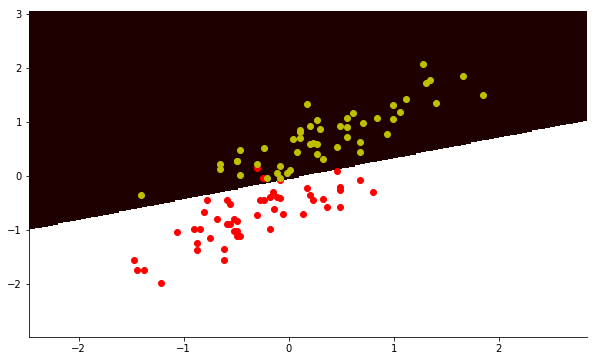

In [21]:
#visualization of linear kernel
m=sklearn.svm.SVC(kernel='linear', C=10).fit(x_train,y_train)
xx=np.arange(min(np.mat(x)[:,0])-1, \
             max(np.mat(x)[:,0])+1, \
             (max(np.mat(x)[:,0])-min(np.mat(x)[:,0]))/200)

yy=np.arange(min(np.mat(x)[:,1])-1, \
             max(np.mat(x)[:,1])+1, \
             (max(np.mat(x)[:,1])-min(np.mat(x)[:,1]))/200)


X,Y=np.meshgrid(xx,yy)
forecast=m.predict(np.c_[X.ravel(),Y.ravel()])


fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.pcolormesh(X,Y,forecast.reshape(X.shape),cmap='pink')

for i in range(len(x)):
    plt.scatter(x[i][0],x[i][1],c='r' if y[i]==1 else 'y')
plt.show()

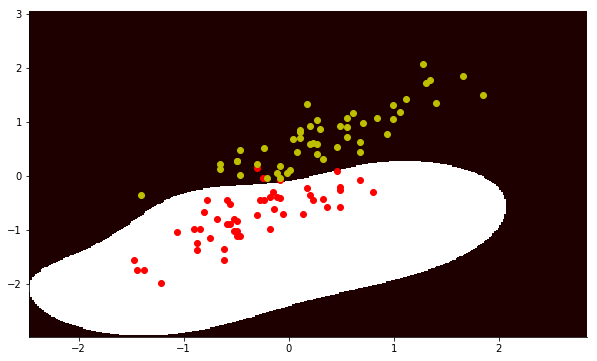

In [22]:
#visualization of gaussian kernel
m=sklearn.svm.SVC(kernel='rbf', C=10).fit(x_train,y_train)
xx=np.arange(min(np.mat(x)[:,0])-1, \
             max(np.mat(x)[:,0])+1, \
             (max(np.mat(x)[:,0])-min(np.mat(x)[:,0]))/200)

yy=np.arange(min(np.mat(x)[:,1])-1, \
             max(np.mat(x)[:,1])+1, \
             (max(np.mat(x)[:,1])-min(np.mat(x)[:,1]))/200)


X,Y=np.meshgrid(xx,yy)
forecast=m.predict(np.c_[X.ravel(),Y.ravel()])


fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.pcolormesh(X,Y,forecast.reshape(X.shape),cmap='pink')

for i in range(len(x)):
    plt.scatter(x[i][0],x[i][1],c='r' if y[i]==1 else 'y')
plt.show()

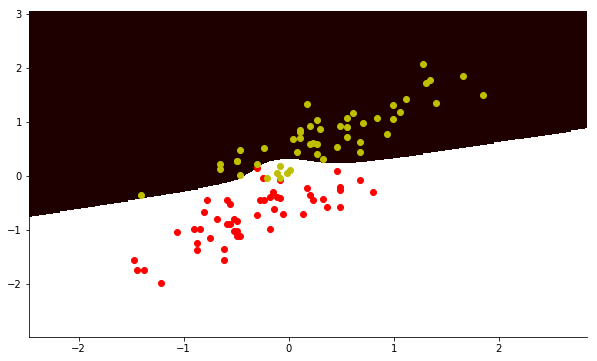

In [23]:
#visualization of polynomial kernel
m=sklearn.svm.SVC(kernel='poly', C=10).fit(x_train,y_train)
xx=np.arange(min(np.mat(x)[:,0])-1, \
             max(np.mat(x)[:,0])+1, \
             (max(np.mat(x)[:,0])-min(np.mat(x)[:,0]))/200)

yy=np.arange(min(np.mat(x)[:,1])-1, \
             max(np.mat(x)[:,1])+1, \
             (max(np.mat(x)[:,1])-min(np.mat(x)[:,1]))/200)


X,Y=np.meshgrid(xx,yy)
forecast=m.predict(np.c_[X.ravel(),Y.ravel()])


fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.pcolormesh(X,Y,forecast.reshape(X.shape),cmap='pink')

for i in range(len(x)):
    plt.scatter(x[i][0],x[i][1],c='r' if y[i]==1 else 'y')
plt.show()
